In [58]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from keras import regularizers, layers, optimizers, initializers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(f'Current GPU allocator: {os.getenv("TF_GPU_ALLOCATOR")}')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(f'Setting memory growth for {gpu}')
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

    

Current GPU allocator: cuda_malloc_async
Setting memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [59]:
study_name = '423_std_powerlog_3'

In [60]:

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [61]:
pd.set_option('display.max_rows', None)

# Aseta näyttämään rajoittamaton määrä sarakkeita
pd.set_option('display.max_columns', None)

In [62]:

pickle_file_path = './data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

pickle_file_path = './data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)

In [63]:
# # FOR TESTING IMAGE AUGEMENTATION
# train_df = train_df.sample(1000)
# test_df = test_df.sample(1000)

In [64]:
feat = pd.read_csv('./data/test.csv')
FEATURE_COLS = feat.columns[1:].tolist()

In [65]:
# train_images_path = './data/train_images/'
# test_images_path = './data/test_images/'    

# train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(train_images_path, f'{x}.jpeg'))
# test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_images_path, f'{x}.jpeg'))

In [66]:
# for column in mean_columns:
#     lower_quantile = train_df[column].quantile(0.005)
#     upper_quantile = train_df[column].quantile(0.985)  
#     train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]

In [67]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for i, trait in enumerate(mean_columns):

#     # Determine the bin edges dynamically based on the distribution of traits
#     bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, 5 + 1))
#     train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# # Concatenate the bins into a final bin
# train_df["final_bin"] = (
#     train_df[[f"bin_{i}" for i in range(len(mean_columns))]]
#     .astype(str)
#     .agg("".join, axis=1)
# )

# # Perform the stratified split using final bin
# train_df = train_df.reset_index(drop=True)
# for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
#     train_df.loc[valid_idx, "fold"] = fold

In [68]:
scaler_feat = RobustScaler()

train_original = train_df.copy()
train_plot = train_df.copy()
sample_df = train_df.copy()

train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]

print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

scaler_tabufeatures_name = f'./NN_search/scaler_tabufeatures_{study_name}_train.pickle'
print(f'Opening feature scaler from {scaler_tabufeatures_name}')
with open(scaler_tabufeatures_name, 'rb') as f:
    scaler_feat = pickle.load(f)

train_df[FEATURE_COLS] = scaler_feat.transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler_feat.transform(valid_df[FEATURE_COLS].values)

# Num Train: 39335 | Num Valid: 9833
Opening feature scaler from ./NN_search/scaler_tabufeatures_423_std_powerlog_3_train.pickle


/tmp/ipykernel_1134090/1629849573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler_feat.transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_1134090/1629849573.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler_feat.transform(valid_df[FEATURE_COLS].values)


In [69]:
import glob

directory_path = './NN_search'
pattern = f"{directory_path}/{study_name}*.h5"

files = glob.glob(pattern)

max_r2_score = float('-inf')
best_model = None

# Käy läpi jokainen tiedosto ja etsi suurin r2_score_inv
for file in files:
    value = float(file.split('best_val')[1].split('_')[1])
    if value > max_r2_score:
        max_r2_score = value
        best_model = file


# Tulosta suurin löydetty r2_score_inv ja vastaava tiedosto
print(f"Best R2-score: {max_r2_score:.5f}")
if best_model:
    print(f"Best model: {best_model}")
else:
    print("No best model found")

best_log_transforms_name =  f'./NN_search/{study_name}_{max_r2_score:.5f}_best_log_transforms.pickle'
best_scalers_name = f'./NN_search/{study_name}_{max_r2_score:.5f}_best_scalers.pickle'

print(f'Opening log transforms from {best_log_transforms_name}')
with open(best_log_transforms_name, 'rb') as f:
    log_transforms = pickle.load(f)

print(f'Opening scalers from {best_scalers_name}')
with open(best_scalers_name, 'rb') as f:
    scaler_transforms = pickle.load(f)


def r2_score_tf(y_true, y_pred):

    try: 
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
        r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2) 
        return tf.reduce_mean(tf.maximum(r2, 0.0))
    except Exception as e:
        # print(f'Error in r2_score_tf: {e}')
        return float('-inf')
    
custom_objects = {"r2_score_tf": r2_score_tf}

nas_model  = tf.keras.models.load_model(best_model, custom_objects=custom_objects)

nas_model.summary()
        

Best R2-score: 0.31963
Best model: ./NN_search/423_std_powerlog_3_best_val_0.31963_model.h5
Opening log transforms from ./NN_search/423_std_powerlog_3_0.31963_best_log_transforms.pickle
Opening scalers from ./NN_search/423_std_powerlog_3_0.31963_best_scalers.pickle
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tabular_data_input (InputLayer  [(None, 163)]       0           []                               
 )                                                                                                
                                                                                                  
 image_features_input (InputLay  [(None, 2560)]      0           []                               
 er)                                                                                              
                          

In [70]:
nas_features = nas_model.layers[-2].output
nas_features = Model(inputs=nas_model.input, outputs=nas_features)

In [71]:
nas_features.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tabular_data_input (InputLayer  [(None, 163)]       0           []                               
 )                                                                                                
                                                                                                  
 image_features_input (InputLay  [(None, 2560)]      0           []                               
 er)                                                                                              
                                                                                                  
 dense_1 (Dense)                (None, 421)          69044       ['tabular_data_input[0][0]']     
                                                                                            

In [72]:

trainable_count_nas = sum([tf.size(v).numpy() for v in nas_model.trainable_weights])
non_trainable_count_nas = sum([tf.size(v).numpy() for v in nas_model.non_trainable_weights])
print(f"Total parameters nas: {trainable_count_nas + non_trainable_count_nas:,}")
print(f"Trainable parameters nas: {trainable_count_nas:,}")
print(f"Non-trainable parameters nas: {non_trainable_count_nas:,}")

Total parameters nas: 2,478,581
Trainable parameters nas: 2,477,739
Non-trainable parameters nas: 842


In [73]:
print(f'Scaler are: {scaler_transforms}')
print(f'Log transforms are: {log_transforms}')

Scaler are: StandardScaler()
Log transforms are: {'X4_mean': 10, 'X11_mean': 'sqrt', 'X18_mean': 'cbrt', 'X50_mean': None, 'X26_mean': 'sqrt', 'X3112_mean': 5}


In [74]:
def augment_image(img):

    img = img / 255.0
    
    img = tf.image.random_flip_left_right(img)
    
    # img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_hue(img, max_delta=0.1)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    img = tf.image.random_jpeg_quality(img, min_jpeg_quality=85, max_jpeg_quality=100)

    # angle = tf.random.uniform([], minval=-np.pi/8, maxval=np.pi/8, dtype=tf.float32)
    # img = tfa.image.rotate(img, angles=angle)

    crop_size = tf.random.uniform(shape=[], minval=420, maxval=480, dtype=tf.int32)
    img = tf.image.random_crop(img, size=[crop_size, crop_size, 3])
    img = tf.image.resize(img, [480, 480]) 


    
    
    theta = tf.random.uniform([], minval=-0.15, maxval=0.15)
    tx = tf.random.uniform([], minval=-45, maxval=45)
    ty = tf.random.uniform([], minval=-45, maxval=45)
    cos_theta = tf.cos(theta)
    sin_theta = tf.sin(theta)
    
    transformation_matrix = [cos_theta, -sin_theta, tx,
                                sin_theta, cos_theta, ty,
                                0, 0]

    img = tfa.image.transform(img, transformation_matrix, interpolation="BILINEAR")
    
    img = img * 255.0

    return img


def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    img = augment_image(img)  
    # img = tf.cast(img, tf.uint8)    

    # tf.print("Final min and max in process_images:", tf.reduce_min(img), tf.reduce_max(img))
    # tf.print("Image type: ", img.dtype)

    return img

def process_image_valid(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    # tf.print("Final min and max in process_image_valid:", tf.reduce_min(img), tf.reduce_max(img))
    # img = tf.cast(img, tf.uint8)
    return img



# Define your dataset processing function
def process_path_train(file_path, tabular_data, targets):
    img = process_image(file_path)
    return (img, img, tabular_data), targets


def process_path_valid(file_path, tabular_data, targets):
    img = process_image_valid(file_path)
    return (img, img, tabular_data), targets

def process_path_test(file_path, tabular_data, dummy):
    img = process_image_valid(file_path)    
    return (img, img, tabular_data), dummy


In [75]:
y_train = train_df[mean_columns]
y_valid = valid_df[mean_columns]


y_train_transformed = y_train.copy()
y_valid_transformed = y_valid.copy()

for target, log_base in log_transforms.items():

    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        y_train_transformed[target] = np.log(y_train[target]) / np.log(log_base)
        y_valid_transformed[target] = np.log(y_valid[target]) / np.log(log_base)

    elif log_base == 'sqrt':
        y_train_transformed[target] = np.sqrt(y_train[target])
        y_valid_transformed[target] = np.sqrt(y_valid[target])

    elif log_base == 'cbrt':
        y_train_transformed[target] = np.cbrt(y_train[target])
        y_valid_transformed[target] = np.cbrt(y_valid[target])

    else:
        y_train_transformed[target] = y_train[target]
        y_valid_transformed[target] = y_valid[target]    


y_train_transformed = scaler_transforms.transform(y_train_transformed)
y_valid_transformed = scaler_transforms.transform(y_valid_transformed)



/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [76]:
BUFFER_SIZE = 50000 
EPOCHS = 1
BATCH_SIZE = 16

train_tabular = train_df[FEATURE_COLS].values
valid_tabular = valid_df[FEATURE_COLS].values

train_images_path = train_df['image_path'].values
valid_images_path = valid_df['image_path'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_tabular, y_train_transformed))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_path, valid_tabular, y_valid_transformed))

train_dataset = train_dataset.map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

len_train = len(train_dataset) * EPOCHS

print(f'LR schedule steps: {len_train}')




LR schedule steps: 2459


In [77]:
#####  KAKSIHAARAINEN AVG MAX IMAGELLA #####



tf.keras.backend.clear_session()
gc.collect()


def r2_score_tf(y_true, y_pred):

    try: 
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
        r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2) 
        return tf.reduce_mean(tf.maximum(r2, 0.0))
    except Exception as e:
        # print(f'Error in r2_score_tf: {e}')
        return float('-inf')


# Asetetaan syötteet
image_input_avg = Input(shape=(480, 480, 3), name='image_input_avg')
image_input_max = Input(shape=(480, 480, 3), name='image_input_max')
tabular_input = Input(shape=(train_tabular.shape[1],), name='tabular_input')

# Luo perus EfficientNetV2M mallit
eff_avg_base = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg', input_tensor=image_input_avg)
eff_max_base = EfficientNetV2M(weights='imagenet', include_top=False, pooling='max', input_tensor=image_input_max)


# # Kloonaa ja nimeä uudelleen mallit
def clone_and_rename(model, prefix):
    # Kloonaa malli ja nimeä kaikki kerrokset uudelleen
    for layer in model.layers:
        layer._name = prefix + '_' + layer.name
    return model

eff_avg_cloned = clone_and_rename(eff_avg_base, 'eff_avg')
eff_max_cloned = clone_and_rename(eff_max_base, 'eff_max')


eff_avg_cloned.trainable = True
for layer in eff_avg_cloned.layers[:-150]:
    layer.trainable = False
eff_max_cloned.trainable = True
for layer in eff_max_cloned.layers[:-150]:
    layer.trainable = False



img_concatenated = Concatenate()([eff_avg_cloned.output, eff_max_cloned.output])

nas_features_layer = nas_features([img_concatenated, tabular_input])
pass_through_layer = Lambda(lambda x: x, name='nas_features')(nas_features_layer)

nas_output = Dense(6, activation='linear', name='final_tune_output')(pass_through_layer)

finetune_model = Model(inputs=[image_input_avg, image_input_max, tabular_input], outputs=nas_output, name='finetune_model')

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,    
    alpha=0.05,
    name="CosineDecay",
    decay_steps=len_train
)

# Aseta oppimisnopeuden aikataulu
finetune_model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mae', metrics=['mse', 'mae', 'mape', r2_score_tf])


In [78]:
trainable_count = sum([tf.size(v).numpy() for v in finetune_model.trainable_weights])
non_trainable_count = sum([tf.size(v).numpy() for v in finetune_model.non_trainable_weights])
print(f"Total parameters: {trainable_count + non_trainable_count:,}")
print(f"Trainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")

print(f'Total parameters from EfficientNetV2M: { (trainable_count + non_trainable_count) - (trainable_count_nas + non_trainable_count_nas):,}')
print(f'Trainable from EfficientNetV2M: {trainable_count - trainable_count_nas:,}')
print(f'Non trainable from EfficientNetV2M: {non_trainable_count - non_trainable_count_nas:,}')

print(f'Trainable fron NAS: {trainable_count_nas:,}')
print(f'Non trainable from NAS: {non_trainable_count_nas:,}')
print(F'Total parameters from NAS: {trainable_count_nas + non_trainable_count_nas:,}')

Total parameters: 108,779,357
Trainable parameters: 52,196,987
Non-trainable parameters: 56,582,370
Total parameters from EfficientNetV2M: 106,300,776
Trainable from EfficientNetV2M: 49,719,248
Non trainable from EfficientNetV2M: 56,581,528
Trainable fron NAS: 2,477,739
Non trainable from NAS: 842
Total parameters from NAS: 2,478,581


In [79]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import io

class TrainImageLoggingCallback(Callback):
    def __init__(self, log_dir, data):
        super(TrainImageLoggingCallback, self).__init__()
        self.log_dir = log_dir
        self.data = data
        self.writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        # Fetch a batch of images
        for (imgs, im2, tab) , tar in self.data.take(1):  # Adjust depending on your dataset structure
            
            # augmented_images = tf.map_fn(augment_image, imgs)
            augmented_images = tf.cast(imgs, tf.uint8)    
        
            # Prepare the image to write to TensorBoard
            with self.writer.as_default():
                tf.summary.image("Augmented Images", augmented_images, step=epoch, max_outputs=20)

            self.writer.flush()


In [80]:

log_folder = f"./logs/all/trial_{study_name}_425_xgbtesti2" # MUUTA!

print(f'Logging tensorboard to {log_folder}')
os.makedirs(log_folder, exist_ok=True)

# Aseta logitiedostojen hakemisto
tensorboard_callback = TensorBoard(log_dir=log_folder, histogram_freq=1, update_freq='batch')

Logging tensorboard to ./logs/all/trial_423_std_powerlog_3_425_xgbtesti2


In [81]:


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f'./NN_search/testifinetus_{study_name}.h5', monitor='val_mae', save_best_only=True, save_weights_only=True, mode = 'min',  verbose = 1),
    tensorboard_callback,
    TrainImageLoggingCallback(log_folder, train_dataset)    
]

history = finetune_model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, verbose=1, callbacks=callbacks)




2024-04-25 16:16:05.833804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39335]
	 [[{{node Placeholder/_0}}]]
2024-04-25 16:16:05.834173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]
2024-04-25 16:16:30.702782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infinetune_model/eff_avg_block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2459/2459 [==============================] - ETA: 0s - loss: 0.6173 - mse: 0.7307 - mae: 0.6173 - mape: 329.3349 - r2_score_tf: 0.2464

2024-04-25 16:36:50.366240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,163]
	 [[{{node Placeholder/_1}}]]
2024-04-25 16:36:50.366547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_2}}]]



Epoch 1: val_mae improved from inf to 0.56900, saving model to ./NN_search/testifinetus_423_std_powerlog_3.h5


2024-04-25 16:40:34.022655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]
2024-04-25 16:40:34.023009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]


2459/2459 [==============================] - 1470s 586ms/step - loss: 0.6173 - mse: 0.7307 - mae: 0.6173 - mape: 329.3349 - r2_score_tf: 0.2464 - val_loss: 0.5690 - val_mse: 0.6379 - val_mae: 0.5690 - val_mape: 362.4297 - val_r2_score_tf: 0.3156


In [82]:
finetune_model.load_weights(f'./NN_search/testifinetus_{study_name}.h5')
# finetune_model.save(f'./NN_search/koe', save_format='tf') # TODO tässä ongelmaa vielä, mutta ei väliä. Malli on jo olemassa ja sitä voi käyttää. 


In [83]:
for target, log_base in log_transforms.items():
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_plot[target] = np.log(train_plot[target]) / np.log(log_base)
        
    elif log_base == 'sqrt':
        train_plot[target] = np.sqrt(train_plot[target])
        
    elif log_base == 'cbrt':
        train_plot[target] = np.cbrt(train_plot[target])
        
    else:
        train_plot[target] = train_plot[target]
        
train_plot[mean_columns] = scaler_transforms.transform(train_plot[mean_columns])

/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [84]:
print(log_transforms)
print(scaler_transforms)

{'X4_mean': 10, 'X11_mean': 'sqrt', 'X18_mean': 'cbrt', 'X50_mean': None, 'X26_mean': 'sqrt', 'X3112_mean': 5}
StandardScaler()


In [85]:
train_original[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


In [86]:
train_plot[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,-0.000167,0.000714,-0.000718,0.000747,-0.002708,0.000992
std,0.999945,0.999787,0.998781,1.001748,0.993986,1.001070
min,-3.624734,-2.468143,-1.318785,-1.841515,-0.737644,-2.909322
25%,-0.703737,-0.613199,-0.726955,-0.692470,-0.569788,-0.659172
50%,0.041257,0.048233,-0.385805,-0.205489,-0.373131,0.019071
75%,0.772798,0.619392,0.551462,0.502425,0.131133,0.746211
max,2.074438,3.056440,3.047026,3.551983,6.357605,2.196641


In [87]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


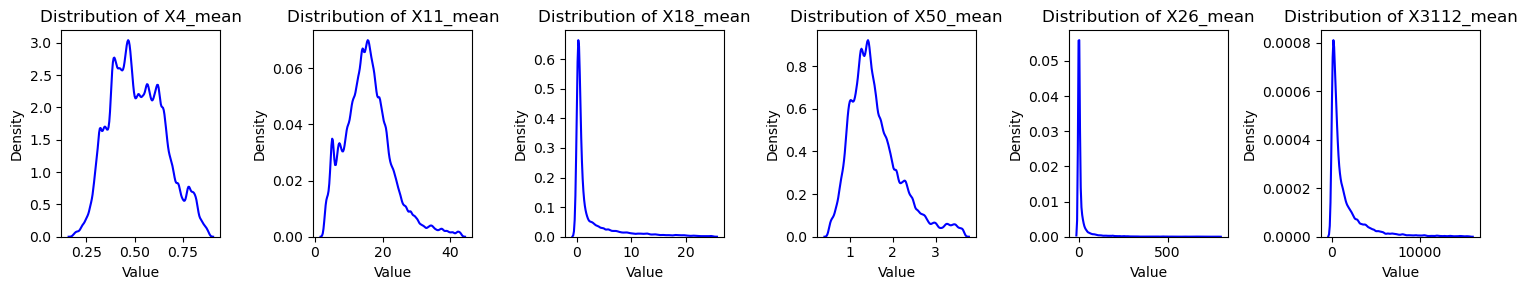

In [88]:
plot_data(train_original, mean_columns)

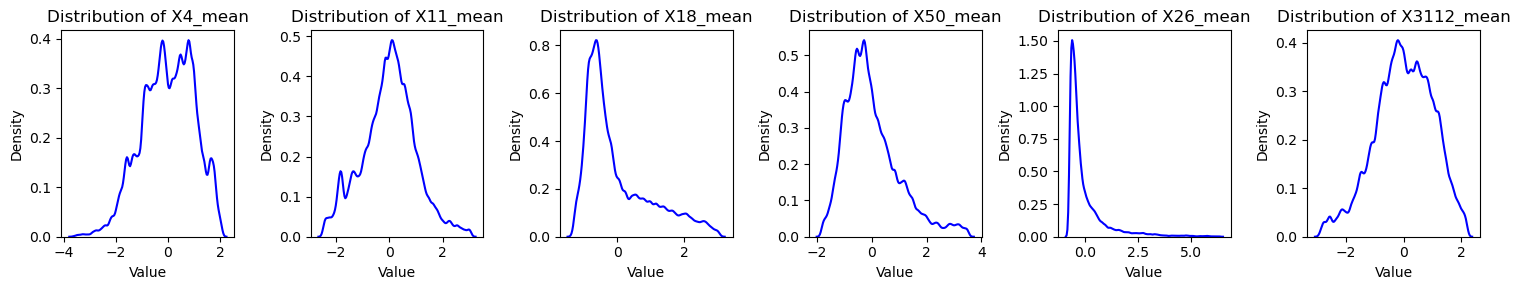

In [89]:
plot_data(train_plot, mean_columns)

In [90]:
# results_training_name = './data/results_finetune_images.pickle'

# if os.path.exists(results_training_name):
#     results_training = pd.read_pickle(results_training_name)
# else:
#     columns = ['Train R2', 'Train MSE', 'Train MAE', 'Train MAPE', 'Valid R2', 'Valid MSE', 'Valid MAE', 'Valid MAPE', 'Train preds Desc', 'Valid preds Desc', 'Test preds Desc' , 'Original data Desc' 'Kaggle R2', 'Scalers', 'Log/Pot transforms']
#     results_training = pd.DataFrame(columns = columns)
#     results_training.index.name = 'Study name'

study_name_result = f'{study_name}_finetuned'

# if study_name_result not in results_training.index:    
#     results_training.loc[study_name] = [None]*len(results_training.columns)

In [91]:


# train_images_path = train_df['image_path'].values
# valid_images_path = valid_df['image_path'].values

# train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_tabular, y_train_transformed))
# valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_path, valid_tabular ,y_valid_transformed))

# train_dataset = train_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# valid_dataset = valid_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# BATCH_SIZE = 32

# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)





In [92]:

# ## TRAINING DATA TEST

# tf.keras.backend.clear_session()
# gc.collect()

# train_pred = finetune_model.predict(train_dataset, verbose=1)

# train_pred = scaler_transforms.inverse_transform(train_pred)

# for i, target in enumerate(mean_columns):
#     print(f'Logpot transforming target : {target}, log transform : {log_transforms[target]}')
#     log_base = log_transforms[target]
#     if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
#         train_pred[:, i] = np.power(log_base, train_pred[:, i])
#     elif log_base == 'sqrt':
#         train_pred[:, i] = np.square(train_pred[:, i])
#     elif log_base == 'cbrt':
#         train_pred[:, i] = np.power(train_pred[:, i], 3)

# R2_train = r2_score(y_train, train_pred)
# MSE_train = mean_squared_error(y_train, train_pred)
# MAE_train = mean_absolute_error(y_train, train_pred)
# MAPE_train = mean_absolute_percentage_error(y_train, train_pred)

# print(f'Train scores:\nR2 : {R2_train:.5f}, MSE : {MSE_train:.5f}, MAE : {MAE_train:.5f}, MAPE : {MAPE_train:.5f}')
# results_training.at[study_name_result, 'Train R2'] = R2_train
# results_training.at[study_name_result, 'Train MSE'] = MSE_train
# results_training.at[study_name_result, 'Train MAE'] = MAE_train
# results_training.at[study_name_result, 'Train MAPE'] = MAPE_train

# trainining_preds_desc = pd.DataFrame(train_pred, columns = mean_columns).describe().to_json()
# results_training.at[study_name_result, 'Train preds Desc'] = trainining_preds_desc

In [93]:

# ## VALIDATION DATA TEST

# tf.keras.backend.clear_session()
# gc.collect()

# valid_pred = finetune_model.predict(valid_dataset, verbose=1)

# valid_pred = scaler_transforms.inverse_transform(valid_pred)


# for i, target in enumerate(mean_columns):
#     log_base = log_transforms[target]
#     if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
#         valid_pred[:, i] = np.power(log_base, valid_pred[:, i])
#     elif log_base == 'sqrt':
#         valid_pred[:, i] = np.square(valid_pred[:, i])
#     elif log_base == 'cbrt':
#         valid_pred[:, i] = np.power(valid_pred[:, i], 3)

# R2_valid = r2_score(y_valid, valid_pred)
# MSE_valid = mean_squared_error(y_valid, valid_pred)
# MAE_valid = mean_absolute_error(y_valid, valid_pred)
# MAPE_valid = mean_absolute_percentage_error(y_valid, valid_pred)

# print(f'Valid scores:\nR2 : {R2_valid:.5f}, MSE : {MSE_valid:.5f}, MAE : {MAE_valid:.5f}, MAPE : {MAPE_valid:.5f}')
# results_training.at[study_name_result, 'Valid R2'] = R2_valid
# results_training.at[study_name_result, 'Valid MSE'] = MSE_valid
# results_training.at[study_name_result, 'Valid MAE'] = MAE_valid
# results_training.at[study_name_result, 'Valid MAPE'] = MAPE_valid

# valid_preds_desc = pd.DataFrame(valid_pred, columns = mean_columns).describe().to_json()
# results_training.at[study_name_result, 'Valid preds Desc'] = valid_preds_desc



In [94]:
# # TEST DATA 

# tf.keras.backend.clear_session()
# gc.collect()

# test_df_copy = test_df.copy()
# submission_df = test_df_copy[['id']].copy()


# test_df_copy[FEATURE_COLS] = scaler_feat.transform(test_df_copy[FEATURE_COLS].values)
# test_features = test_df_copy[FEATURE_COLS].values
# test_images_path = test_df_copy['image_path'].values

# dummy_y = np.zeros((len(test_df_copy), 6))

# test_dataset = tf.data.Dataset.from_tensor_slices((test_images_path, test_features, dummy_y))
# test_dataset = test_dataset.map(process_path_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# predictions = finetune_model.predict(test_dataset, verbose=1)

# predictions = scaler_transforms.inverse_transform(predictions)


# for i, target in enumerate(mean_columns):
#     print(f'Logpot transforming target: : {target}, log transform : {log_transforms[target]}')
#     log_base = log_transforms[target]
#     if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
#         predictions[:, i] = np.power(log_base, predictions[:, i])
#     elif log_base == 'sqrt':
#         predictions[:, i] = np.square(predictions[:, i])
#     elif log_base == 'cbrt':
#         predictions[:, i] = np.power(predictions[:, i], 3)

# test_preds_desc =  pd.DataFrame(predictions, columns = mean_columns).describe().to_json()
# results_training.at[study_name_result, 'Test preds Desc'] = test_preds_desc 


In [95]:
# print(predictions.shape)

In [96]:

# target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

# submission_df[target_columns] = predictions


In [97]:
# original_data_desc = train_original[mean_columns].describe().to_json()
# results_training.at[study_name_result, 'Original data Desc'] = original_data_desc



In [98]:
# print(f'{str(log_transforms.items())}')
# print(f'{str(scaler_transforms)}')

# results_training.at[study_name_result, 'Scalers'] = f'{scaler_transforms}'
# results_training.at[study_name_result, 'Log/Pot transforms'] = f'{str(log_transforms.items())}'



In [99]:
# results_training.at[study_name_result, 'Kaggle R2'] = None


# # results_training.drop('423_std_powerlog_3', inplace=True)
# # results_training.head()

# for index, row in results_training.iterrows():
#     print(f"Study Name: {index}")
#     print(f'Kaggle R2: {row["Kaggle R2"]}')
#     print(f"Train R2: {row['Train R2']}, Train MSE: {row['Train MSE']}, Train MAE : {row['Train MAE']}, Train MAPE: {row['Train MAPE']}")
#     print(f'Valid R2: {row["Valid R2"]}, Valid MSE: {row["Valid MSE"]}, Valid MAE: {row["Valid MAE"]}, Valid MAPE: {row["Valid MAPE"]}')
#     print("-" * 50)
#     print("Train preds Description:")
#     display(pd.read_json(row['Train preds Desc']))
#     print("Valid preds Description:")
#     display(pd.read_json(row['Valid preds Desc']))
#     print("Test preds Description:")
#     display(pd.read_json(row['Test preds Desc']))
#     print("Original data Description:")
#     display(pd.read_json(row['Original data Desc']))
    

In [100]:
# submission_df.head()

In [101]:
# print(submission_df.info())

# submission_df.to_csv('./data/submission.csv', index=False)

In [102]:
# with open(results_training_name, 'wb') as f:
#     results_training.to_pickle(f)

In [103]:
feature_model_output = finetune_model.get_layer('nas_features')
feature_model = Model(inputs=finetune_model.input, outputs=feature_model_output.output)


In [104]:
train_all_paths = train_original['image_path'].values
train_all_features = train_original[FEATURE_COLS].values
dummy_y = np.zeros((len(train_original), 6))

train_all_dataset = tf.data.Dataset.from_tensor_slices((train_all_paths, train_all_features, dummy_y))
train_all_dataset = train_all_dataset.map(process_path_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_all_dataset = train_all_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_features = feature_model.predict(train_all_dataset, verbose=1)

train_original[f'model_features_{study_name_result}'] = train_features.tolist()

2024-04-25 16:40:41.697195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [49168,6]
	 [[{{node Placeholder/_2}}]]
2024-04-25 16:40:41.697626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [49168,6]
	 [[{{node Placeholder/_2}}]]


1537/1537 [==============================] - 851s 550ms/step


In [105]:
train_original.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_bdod_60.100cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_30.60cm_mean_0.01_deg,SOIL_cec_5.15cm_mean_0.01_deg,SOIL_cec_60.100cm_mean_0.01_deg,SOIL_cfvo_0.5cm_mean_0.01_deg,SOIL_cfvo_100.200cm_mean_0.01_deg,SOIL_cfvo_15.30cm_mean_0.01_deg,SOIL_cfvo_30.60cm_mean_0.01_deg,SOIL_cfvo_5.15cm_mean_0.01_deg,SOIL_cfvo_60.100cm_mean_0.01_deg,SOIL_clay_0.5cm_mean_0.01_deg,SOIL_clay_100.200cm_mean_0.01_deg,SOIL_clay_15.30cm_mean_0.01_deg,SOIL_clay_30.60cm_mean_0.01_deg,SOIL_clay_5.15cm_mean_0.01_deg,SOIL_clay_60.100cm_mean_0.01_deg,SOIL_nitrogen_0.5cm_mean_0.01_deg,SOIL_nitrogen_100.200cm_mean_0.01_deg,SOIL_nitrogen_15.30cm_mean_0.01_deg,SOIL_nitrogen_30.60cm_mean_0.01_deg,SOIL_nitrogen_5.15cm_mean_0.01_deg,SOIL_nitrogen_60.100cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_15.30cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_ocd_5.15cm_mean_0.01_deg,SOIL_ocd_60.100cm_mean_0.01_deg,SOIL_ocs_0.30cm_mean_0.01_deg,SOIL_phh2o_0.5cm_mean_0.01_deg,SOIL_phh2o_100.200cm_mean_0.01_deg,SOIL_phh2o_15.30cm_mean_0.01_deg,SOIL_phh2o_30.60cm_mean_0.01_deg,SOIL_phh2o_5.15cm_mean_0.01_deg,SOIL_phh2o_60.100cm_mean_0.01_deg,SOIL_sand_0.5cm_mean_0.01_deg,SOIL_sand_100.200cm_mean_0.01_deg,SOIL_sand_15.30cm_mean_0.01_deg,SOIL_sand_30.60cm_mean_0.01_deg,SOIL_sand_5.15cm_mean_0.01_deg,SOIL_sand_60.100cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_100.200cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,SOIL_soc_30.60cm_mean_0.01_deg,SOIL_soc_5.15cm_mean_0.01_deg,SOIL_soc_60.100cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_ban

In [106]:
pickle_file_path = './data/train_testi_df.pickle'

print(f'Saving train_df to {pickle_file_path}')
with open(pickle_file_path, 'wb') as f:
    pickle.dump(train_original, f)

Saving train_df to ./data/train_testi_df.pickle


In [107]:
test_all_paths = test_df['image_path'].values
test_all_features = test_df[FEATURE_COLS].values
dummy_y = np.zeros((len(test_df), 6))

test_all_dataset = tf.data.Dataset.from_tensor_slices((test_all_paths, test_all_features, dummy_y))
test_all_dataset = test_all_dataset.map(process_path_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_all_dataset = test_all_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_features = feature_model.predict(test_all_dataset, verbose=1)

test_df[f'model_features_{study_name_result}'] = test_features.tolist()

2024-04-25 16:55:22.510425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [6545,6]
	 [[{{node Placeholder/_2}}]]
2024-04-25 16:55:22.511599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [6545,6]
	 [[{{node Placeholder/_2}}]]


205/205 [==============================] - 106s 513ms/step


In [108]:
print(test_df[f'model_features_{study_name_result}'].head())

0    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
1    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
2    [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
4    [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...
Name: model_features_423_std_powerlog_3_finetuned, dtype: object


In [109]:
test_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_bdod_60.100cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_30.60cm_mean_0.01_deg,SOIL_cec_5.15cm_mean_0.01_deg,SOIL_cec_60.100cm_mean_0.01_deg,SOIL_cfvo_0.5cm_mean_0.01_deg,SOIL_cfvo_100.200cm_mean_0.01_deg,SOIL_cfvo_15.30cm_mean_0.01_deg,SOIL_cfvo_30.60cm_mean_0.01_deg,SOIL_cfvo_5.15cm_mean_0.01_deg,SOIL_cfvo_60.100cm_mean_0.01_deg,SOIL_clay_0.5cm_mean_0.01_deg,SOIL_clay_100.200cm_mean_0.01_deg,SOIL_clay_15.30cm_mean_0.01_deg,SOIL_clay_30.60cm_mean_0.01_deg,SOIL_clay_5.15cm_mean_0.01_deg,SOIL_clay_60.100cm_mean_0.01_deg,SOIL_nitrogen_0.5cm_mean_0.01_deg,SOIL_nitrogen_100.200cm_mean_0.01_deg,SOIL_nitrogen_15.30cm_mean_0.01_deg,SOIL_nitrogen_30.60cm_mean_0.01_deg,SOIL_nitrogen_5.15cm_mean_0.01_deg,SOIL_nitrogen_60.100cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_15.30cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_ocd_5.15cm_mean_0.01_deg,SOIL_ocd_60.100cm_mean_0.01_deg,SOIL_ocs_0.30cm_mean_0.01_deg,SOIL_phh2o_0.5cm_mean_0.01_deg,SOIL_phh2o_100.200cm_mean_0.01_deg,SOIL_phh2o_15.30cm_mean_0.01_deg,SOIL_phh2o_30.60cm_mean_0.01_deg,SOIL_phh2o_5.15cm_mean_0.01_deg,SOIL_phh2o_60.100cm_mean_0.01_deg,SOIL_sand_0.5cm_mean_0.01_deg,SOIL_sand_100.200cm_mean_0.01_deg,SOIL_sand_15.30cm_mean_0.01_deg,SOIL_sand_30.60cm_mean_0.01_deg,SOIL_sand_5.15cm_mean_0.01_deg,SOIL_sand_60.100cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_100.200cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,SOIL_soc_30.60cm_mean_0.01_deg,SOIL_soc_5.15cm_mean_0.01_deg,SOIL_soc_60.100cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_ban

In [110]:
pickle_file_path = './data/test_testi_df.pickle'

print(f'Saving test_df to {pickle_file_path}')
with open(pickle_file_path, 'wb') as f:
    pickle.dump(test_df, f)


Saving test_df to ./data/test_testi_df.pickle


: 